# Upper Slope & Axis 75 kHz ADCP

Primary notebook to create various spectral and velocity plots for either the Upper Slope or Axis ADCP velocity data.

## Imports

Necessary modules for analysis.

In [2]:
# import modules
import xarray as xr
import datetime
import cmath
from datetime import datetime
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import numpy as np
import numpy.ma as ma
import scipy.signal as sig
import scipy.integrate as integ
import scipy.interpolate as interp
import pandas as pd
import seawater as sea
from scipy.stats import chi2
from scipy.io import loadmat
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib notebook

## Data

Choose Upper Slope or Axis data, in NetCDF format, and visualise data to check for coverage.

In [268]:
# import data

adcp = 'Axis55'     # Slope, Axis, Axis55
name = adcp         # name of instrument, for plots

if adcp == 'Slope':
    ds = xr.open_dataset(f'../Data/{adcp}All/{adcp}_all.nc')
elif adcp == 'Axis':
    ds = xr.open_dataset(f'../Data/{adcp}All/{adcp}/{adcp}_all.nc')
elif adcp == 'Axis55':
    ds = xr.open_dataset(f'../Data/AxisAll/{adcp}/{adcp}_all.nc')
    name = 'Axis'   # for consistent naming between Axis 75 and 55 kHz

#ds = xr.open_dataset('../Data/SlopeAll/4.nc')    # for opening original datasets
print(ds)

# plot dataset to check data quality
# fig,ax = plt.subplots(figsize=(9,3))
# ax.pcolormesh(ds.time, -ds.depth, ds.u.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
# plt.show()

<xarray.Dataset>
Dimensions:   (depth: 49, time: 101859)
Coordinates:
  * depth     (depth) int64 13 33 53 73 93 113 133 ... 873 893 913 933 953 973
  * time      (time) datetime64[ns] 2017-01-18T19:07:30.000009984 ... 2019-12-24T01:07:30.000009984
Data variables:
    u         (time, depth) float64 ...
    v         (time, depth) float64 ...
    w         (time, depth) float64 ...
    pressure  (time) float32 ...
    temp      (time) float32 ...


## Depth

Truncate data to a specific depth interval to eliminate unreliable data (from visual inspection of velocity plots), approximately 50-100 m from the upper and lower extremes of the ADCP beams.

In [237]:
# function to find nearby indices for desired depth values
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest depth value

array = ds.depth    # input array to process 
if adcp=='Slope':
    upval = 100         # upper depth for data, metres (upper slope)
    lowval = 330        # lower depth for data (upper slope)
elif adcp=='Axis':
    upval = 400         # upper depth for data, metres (axis)
    lowval = 900        # lower depth for data (axis)
elif adcp=='Axis55':
    upval = 400         # upper depth for data, metres (axis), to match earlier Axis records
    lowval = 900        # lower depth for data (axis)
    
upidx = find_nearest(array, upval)                 # index of upper depth cutoff
lowidx = find_nearest(array,lowval)+1              # index of lower depth cutoff 

print("Index at upper depth cutoff:", upidx)
print("Value at upper depth cutoff:", -ds.depth.values[upidx], "metres" )
print('---')
print("Index at lower depth cutoff:", lowidx)
print("Value at lower depth cutoff:", -ds.depth.values[lowidx], "metres" )

depth = np.array(ds.depth[upidx:lowidx+1])         # remove unwanted depths
dup_stamp = int(-depth[0])                         # depth stamps for use in output filenames
dlow_stamp = int(-depth[-1])

print('---')
print("Length of new depth array: ", len(depth))   # new depth interval
print(f'Upper limit at',dup_stamp,'metres')         # depth for upper PSD
print(f'Lower limit at',dlow_stamp,'metres')        # depth for lower PSD

Index at upper depth cutoff: 19
Value at upper depth cutoff: -393 metres
---
Index at lower depth cutoff: 45
Value at lower depth cutoff: -913 metres
---
Length of new depth array:  27
Upper limit at -393 metres
Lower limit at -913 metres


## Time

Find specific time range and format dates for plotting. If significant *consecutive* NaN values are present, then shorten series for that particular segment.

In [269]:
datestimes = pd.to_datetime(ds.time.values)            # convert to datetime from datetime64
datestimes = pd.Series(datestimes)                     # convert to pandas dataframe

start_date = pd.datetime(2018,1,1)
end_date = pd.datetime(2019,1,1)
start = datestimes[datestimes >= start_date].index[0]                # desired start date
end = datestimes[datestimes < end_date].index[-1]                    # desired end date
time_total = ds.time.values[start:end]                               # total desired interval
print("Desired time range:",np.min(time_total),np.max(time_total))   # print to check desired interval

# check time series for significant data gaps
depth_test = ds.depth[upidx]                           # upper depth 
print('checked at depth',-depth_test.values,'m')
print('')

u_test = np.array(ds.u[start:end,upidx])               # u data at this depth
counter = 0                                            # counter to keep track of # of consecutive NaN values
for i in range(len(time_total)):                       # loop to count consecutive NaN values
    if np.isnan(u_test[i])==True:                      # add to counter if NaN = true
        counter += 1
        if counter==288:                               # a consecutive day of NaN
            dead = i-288                               # date time series hits significant NaN interval
            print('Good data until:',np.max(time_total[dead+1]))
            print('')
        elif counter > 288 and i < len(time_total)-2: 
            if np.isnan(u_test[i+1])==False:
                print('Good data resets at:',time_total[i])
    else:                                              # reset counter if NaN inconsistent
        counter = 0       

# usable interval, for next steps
time = ds.time.values[start:end]   

# set year time stamp for output filenames
t_stamp = f'{datestimes.dt.year[start]}'

# plot specified time interval to check data quality
# u_test = ds.u[start:end,upidx:lowidx+1]
# fig,ax = plt.subplots(figsize=(9,3))
# ax.pcolormesh(time, -depth, u_test.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
# plt.show()

Desired time range: 2018-01-01T00:07:30.000003328 2018-12-31T23:37:30.000000000
checked at depth -393 m

Good data until: 2018-06-13T05:07:30.000006656

Good data resets at: 2018-06-26T15:22:30.000000000
Good data until: 2018-08-03T00:07:29.999993344

Good data resets at: 2018-08-08T20:07:29.999996672
Good data until: 2018-11-23T00:37:29.999996672

Good data resets at: 2018-11-29T00:22:30.000000000
Good data until: 2018-12-20T23:22:29.999993344

Good data resets at: 2018-12-25T00:07:30.000003328
Good data until: 2018-12-26T18:37:29.999996672

Good data resets at: 2018-12-29T23:07:29.999996672


/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


## Clean

Data rotated based on a visual estimate of along-slope angle, as 30$^{\circ}$. This could be updated to reflect Thomson's work at the A1 site, relatively nearby.

Data are also interpolated to deal with minor instances of NaN values in both depth and time. Consistent NaN intervals are dealt with in the Time section, above.

In [245]:
# process to rotate, interpolate, and filter raw data (no significant data gaps)

# rotate data
theta_along_slope = np.radians(30)                       # rotation angle in radians, 30 degrees
u_vec = ds.u[start:end,upidx:lowidx+1] + 1j*ds.v[start:end,upidx:lowidx+1]  # vector form of horizontal velocity
u_vec_new = u_vec*np.exp(-1j*theta_along_slope)          # rotated velocity vector
u_rot = np.real(u_vec_new)                               # u_new = Re(rotated vector)
v_rot = np.imag(u_vec_new)                               # v_new = Im(rotated vector)

# filter NaN instances from data
t = len(time)                  # number of time data points after checking for consistent NaN intervals
d = len(depth)                 # number of depth data points after removing unwanted depths

uorig = np.empty([t,d])        # empty array for rotated u data
vorig = np.empty([t,d])        # empty array for rotated v data

for j in range(d):                       # loop to interpolate velocities at each depth
    utemp = pd.Series(u_rot[:,j])
    uint = utemp.interpolate(method="linear", limit_direction='both')
    uorig[:,j] = uint                    # set interpolated data to original array
    vtemp = pd.Series(v_rot[:,j])
    vint = vtemp.interpolate(method="linear", limit_direction='both')
    vorig[:,j] = vint                    # set interpolated data to original array
    
# low pass Butterworth filter for 40 hour cut-off to remove 30 hour tides

fs = 4                # samples per HOUR for entire time series
fc = 0.025            # 40 hour low pass filter cut-off
Wn = fc / (fs / 2)    # normalised cut-off frequencies
b, a = sig.butter(8, Wn,'lowpass')  # digital butterworth filter
w, h = sig.freqz(b, a)    
    
ulp = np.empty([t,d])          # empty array for low-pass filtered u values
vlp = np.empty([t,d])          # empty array for low-pass filtered v values
uhp = np.empty([t,d])          # empty array for residual u values
vhp = np.empty([t,d])          # empty array for residual v values

for j in range(d):             # loop for filtered and residual velocities
    uint = uorig[:,j]
    ulp[:,j] = sig.filtfilt(b, a, uint)
    uhp[:,j] = uint - ulp[:,j]
    
    vint = vorig[:,j]
    vlp[:,j] = sig.filtfilt(b, a, vint)
    vhp[:,j] = vint - vlp[:,j]

In [106]:
# process for w (run after horizontal)

# w_new = ds.w[start:end,upidx:lowidx+1]   # w based on time and depth filters
# worig = np.empty([t,d])                  # empty array for rotated w data
# wlp = np.empty([t,d])                    # empty array for low-pass filtered w values
# whp = np.empty([t,d])                    # empty array for residual w values

# for j in range(d):                       # loop to filter NaN instances from velocities at each depth
#     wtemp = pd.Series(w_new[:,j])
#     wint = wtemp.interpolate(method="linear", limit_direction='both',limit=96)
#     worig[:,j] = wint                    # set interpolated data to original array
    
# for j in range(d):                       # loop for filtered and residual velocities
#     wint = worig[:,j]
#     wlp[:,j] = sig.filtfilt(b, a, wint)
#     whp[:,j] = wint - wlp[:,j]

# Spectra

PSD, spectrograms, and rotary spectra.

## PSD

Removes the mean from upper and lower depth limits. Also obtains depth mean data for an average spectra through depth. Performs Welch FFT with adjustable parameters, using a Parzen window and what seems to be an optimal averaging process, based on visual analysis of spectral output. Calculates 95% confidence intervals using a chi$^2$ method. GM reference spectra is being adjusted.

In [246]:
# remove mean from upper and lower depth limits

# upper depth limit
umup = uorig[:,0] - np.mean(uorig[:,0]) 
vmup = vorig[:,0] - np.mean(vorig[:,0])

# lower depth limit
umlow = uorig[:,-1] - np.mean(uorig[:,-1]) 
vmlow = vorig[:,-1] - np.mean(vorig[:,-1])

In [247]:
# Welch FFT
fs_x = 4                        # 4 samples per HOUR
window_x = 'parzen'             # optimal window for averaging
nperseg_x = int(len(time)/40)   # find optimal average for nperseg, use /40 for annual, /20 for seasonal       

# lower depth
umlow_f, umlow_PSD = sig.welch(umlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vmlow_f, vmlow_PSD = sig.welch(vmlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

# upper depth
umup_f, umup_PSD = sig.welch(umup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vmup_f, vmup_PSD = sig.welch(vmup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

In [248]:
# error bars (95% confidence intervals)

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = len(time) / (nperseg_x / 2)              # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

umlow_lower = umlow_PSD * cint[0]             # define upper and lower confidence values
umlow_upper = umlow_PSD * cint[1]
vmlow_lower = vmlow_PSD * cint[0]             # define upper and lower confidence values
vmlow_upper = vmlow_PSD * cint[1]

umup_lower = umup_PSD * cint[0]               # define upper and lower confidence values
umup_upper = umup_PSD * cint[1]
vmup_lower = vmup_PSD * cint[0]               # define upper and lower confidence values
vmup_upper = vmup_PSD * cint[1]

In [249]:
# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')   # get GM data from separate code
gm_freq = gm[:, 0]
gm_psd = gm[:, 1]

In [250]:
# noise floor using 'single ping uncertainty' i.e. standard deviation

if adcp == 'Slope' or adcp == 'Axis':
    std = 0.076              # single ping accuracy from instrument datasheet = standard deviation [m/s]
    pings = 1                # pings per ensemble
    ens_t = 2                # ensemble time
elif adcp == 'Axis55':
    std = 0.0156             # from Nortek deployment software and ONC parameters
    pings = 6                # pings per ensemble
    ens_t = 108              # ensemble time

avg_t = 900                               # averaged time resolution of data, 15 minutes
total_pings = int((avg_t/ens_t)*pings)    # total number of pings per averaged interval
std = std/np.sqrt(total_pings)            # standard error of the mean for this interval
var = std**2                              # [(m/s)**2]
dx = np.max(umup_f/3600)                  # Nyquist frequency to define bandwidth range, 5.55e-4 Hz
noise_floor = var/dx                      # total noise power [(m/s)**2 /Hz]

<IPython.core.display.Javascript object>


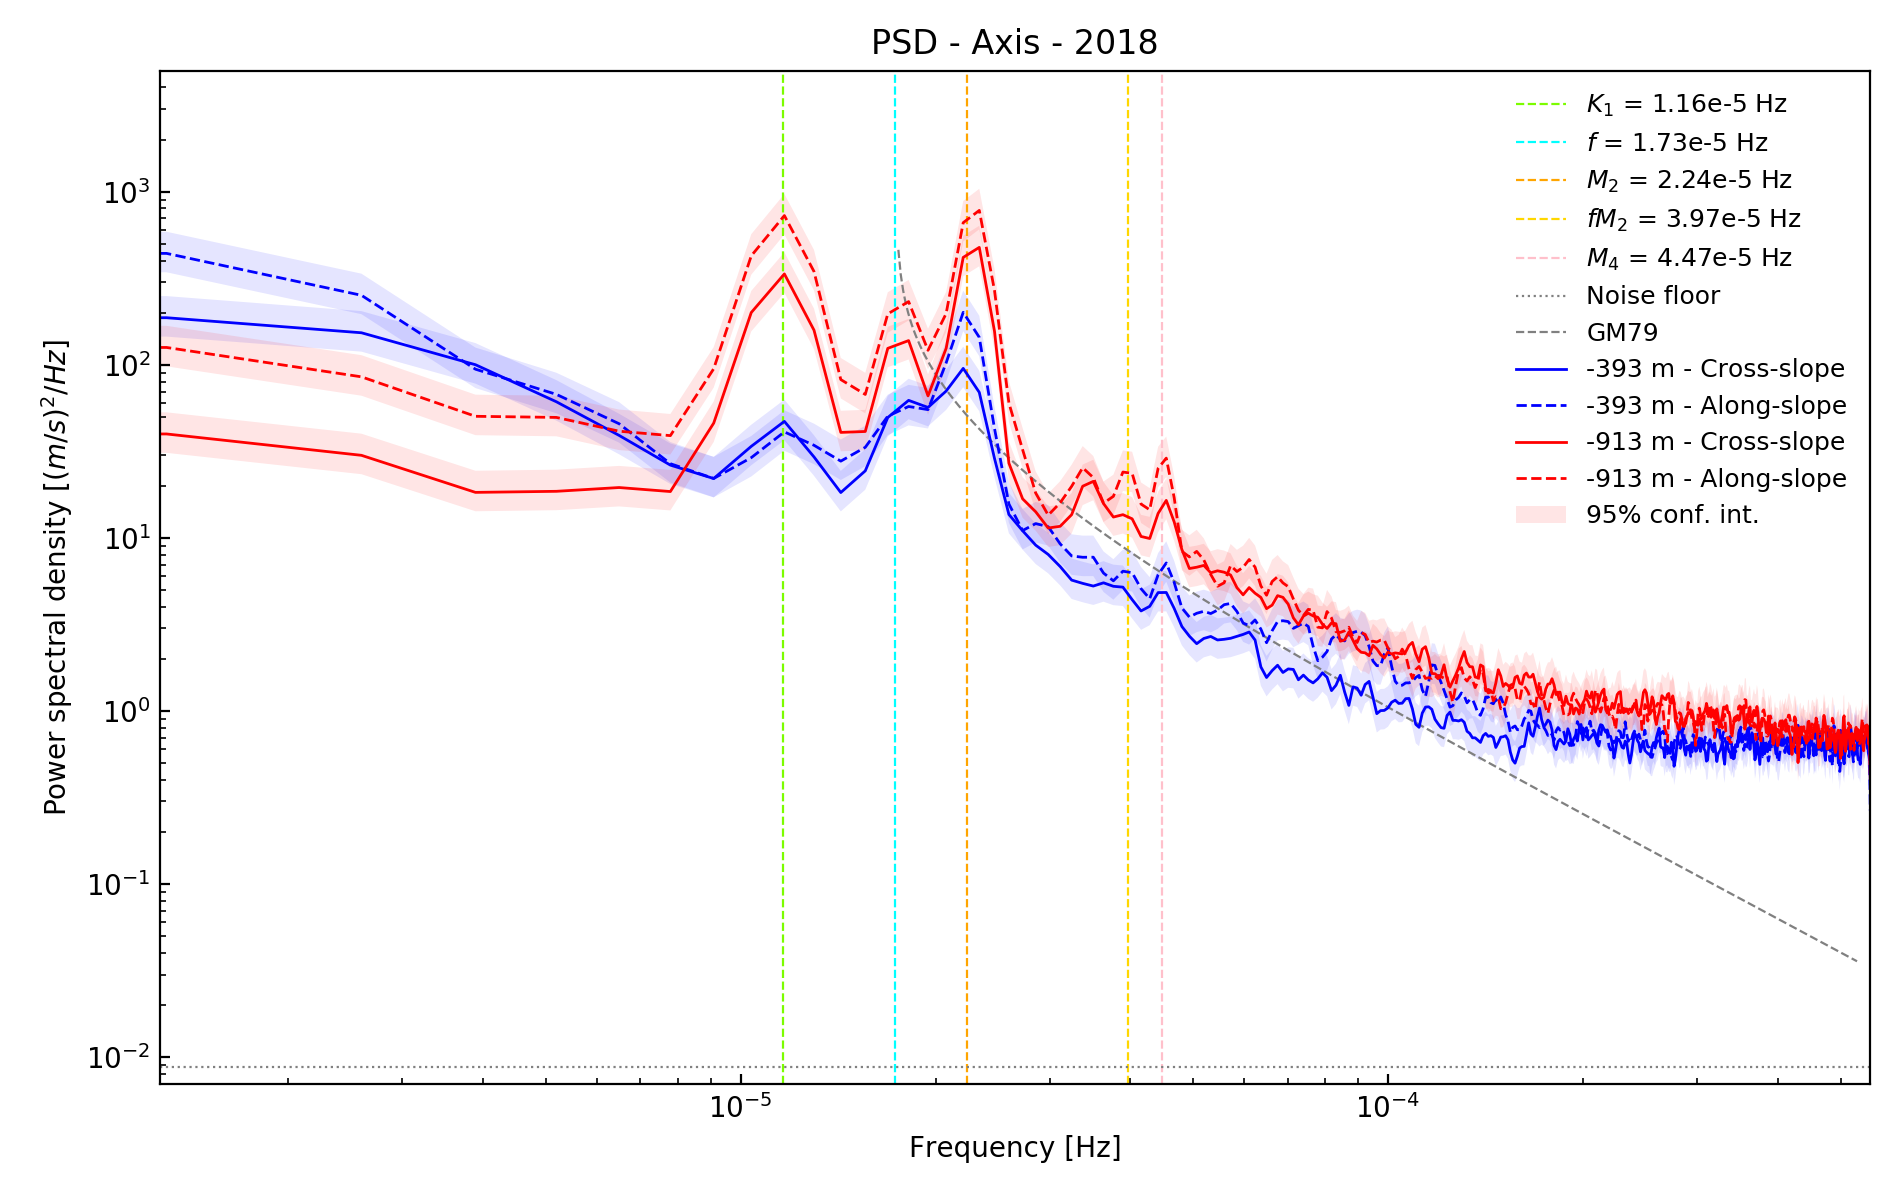

In [252]:
# plot PSD

fig, ax = plt.subplots(1,1,figsize=(9.5,6))

ax.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") # constituents
ax.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz")    
ax.axvline(2.236e-5, color ='orange',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
ax.axvline(3.968e-5, color ='gold',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
ax.axvline(4.472e-5, color ='pink',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
ax.set_ylim(7e-3,5e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 
ax.tick_params(axis='both', direction='in', which='both')
ax.set_title(f'PSD - {name} - {t_stamp}')
ax.set_ylabel('Power spectral density [$(m/s)^2/Hz$]')
ax.set_xlabel('Frequency [Hz]')

ax.axhline(noise_floor,color='gray',ls=':',lw=0.8,label='Noise floor')
ax.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='gray',lw=0.8,ls='--', label='GM79') # 1/2 GM for components
ax.loglog(umup_f/3600, umup_PSD*3600, label=f'{dup_stamp} m - Cross-slope',color='blue',lw=1)
ax.loglog(vmup_f/3600, vmup_PSD*3600, label=f'{dup_stamp} m - Along-slope',color='blue',ls='--',lw=1)
ax.loglog(umlow_f/3600, umlow_PSD*3600, label=f'{dlow_stamp} m - Cross-slope',color='red',lw=1)
ax.loglog(vmlow_f/3600, vmlow_PSD*3600, label=f'{dlow_stamp} m - Along-slope',color='red',ls='--',lw=1)

ax.fill_between(umup_f/3600, umup_lower*3600, umup_upper*3600, facecolor='blue', alpha=0.1)
ax.fill_between(vmup_f/3600, vmup_lower*3600, vmup_upper*3600, facecolor='blue', alpha=0.1)
ax.fill_between(umlow_f/3600, umlow_lower*3600, umlow_upper*3600, facecolor='red', alpha=0.1)
ax.fill_between(vmlow_f/3600, vmlow_lower*3600, vmlow_upper*3600, facecolor='red', alpha=0.1, label='95% conf. int.')

fig.tight_layout()
plt.legend(loc='best',frameon=False,fontsize=9)
plt.show()

plt.savefig(fname='./plots/psd_plots/psd_'+adcp+'_'+t_stamp+'.pdf',format='pdf')

In [ ]:
# w PSD, run after horizontal processes

# wmup = worig[:,0] - np.mean(worig[:,0])
# wmlow = worig[:,-1] - np.mean(worig[:,-1])

# wmlow_f, wmlow_PSD = sig.welch(wmlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
# wmup_f, wmup_PSD = sig.welch(wmup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

# wmlow_lower = wmlow_PSD * cint[0]             # define upper and lower confidence values
# wmlow_upper = wmlow_PSD * cint[1]
# wmup_lower = wmup_PSD * cint[0]               # define upper and lower confidence values
# wmup_upper = wmup_PSD * cint[1]

In [15]:
# PSD for w velocities, ***update to match horizontal***

# fig, axs = plt.subplots(2,1,figsize=(10,8), sharex=True, sharey=True)
# (ax1,ax2) = axs
# fig.subplots_adjust(hspace=0.03, wspace=0)

# ax1.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") 
# ax1.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz")    
# ax1.axvline(2.236e-5, color ='orange',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
# ax1.axvline(3.968e-5, color ='gold',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
# ax1.axvline(4.472e-5, color ='pink',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
# ax1.tick_params(axis='both', direction='in', which='both')
# ax1.loglog(wmup_f/3600, wmup_PSD*3600)
# #ax1.set_ylim(1e-3,5e2)
# #ax1.set_ylim(1e-2,1e1)
# #ax1.set_xlim(np.min(wmup_f/3600),np.max(wmup_f/3600))

# ax2.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8)
# ax2.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8)
# ax2.axvline(2.236e-5, color ='orange',ls='--',lw=0.8)
# ax2.axvline(3.968e-5, color ='gold',ls='--',lw=0.8)
# ax2.axvline(4.472e-5, color ='pink',ls='--',lw=0.8)
# ax2.tick_params(axis='both', direction='in', which='both')
# ax2.loglog(wmlow_f/3600, wmlow_PSD*3600)

# fig.text(0.805, 0.7, f'Depth {dup_stamp} m', va='center',rotation='270')
# fig.text(0.805, 0.3, f'Depth {dlow_stamp} m', va='center',rotation='270')
# fig.text(0.5,0.90,f'$w$ PSD - {name} - Annual {t_stamp}', ha='center', fontsize=12)
# fig.text(0.04, 0.5, 'Power spectral density [$(m/s)^2/Hz$]', va='center', rotation='vertical')
# fig.text(0.5,0.06,'Frequency [Hz]',ha='center')

# ax1.fill_between(wmup_f/3600, wmup_lower*3600, wmup_upper*3600, facecolor='green', alpha=0.1)
# ax2.fill_between(wmlow_f/3600, wmlow_lower*3600, wmlow_upper*3600, facecolor='green', alpha=0.1, label='95% conf. int.')

# plt.subplots_adjust(right=0.8)
# fig.legend(loc=(0.83,0.695), fontsize=9, frameon=False)
# plt.show()

# #plt.savefig(fname='./plots/psd_plots/psd_'+adcp+'_w_'+t_stamp+'.pdf',format='pdf')

## Rotary

Creates rotary spectra for the mean-removed and cleaned velocity data, and specific depths. Defines a function to return the CW, CCW, cross, and quadrature spectra for any u and v velocity vectors.

Based on Thomson, R. (1997). Data Analysis Methods in Physical Oceanography. pp.427-432,494-500; Gonella, J. (1972) Deep Sea Res. 833-846, and https://pyoceans.github.io/python-oceans/ocfis.html, and further adapted for averaging (Welch) PSD and CSD processes.

In [253]:
# rotary spectra function

def spec_rot(u, v):
    fs = 4                    # samples per hour
    nps = int(len(time)/20)   # find optimal average for nperseg, use /40 for annual, /20 for seasonal
    win = 'parzen'            # window
    puf, pu = sig.welch(u,fs=fs,window=win,nperseg=nps,return_onesided=False)           # auto-spectrum for u
    pvf, pv = sig.welch(v,fs=fs,window=win,nperseg=nps,return_onesided=False)           # auto-spectrum for v
    cuvf, cuv = sig.csd(v,u,fs=fs,window=win,nperseg=nps,return_onesided=False)         # cross spectra (u,v --> v,u)
    quv = cuv.imag                                      # quadrature spectrum, imaginary part of cross spectra
    cw = ((pu + pv) - (2*quv)) / 2                      # rotatory components
    ccw = ((pu + pv) + (2*quv)) / 2
    F = puf                                             # frequency range (two-sided)
    return cuv, quv, cw, ccw, F

In [254]:
# get rotary spectra
d_idx_low = -1                                             # depth index, use -1 for lower, 0 for upper
d_stamp_low = str(int(depth[d_idx_low]))                   # depth stamp for figures
rot_u_low = uorig[:,d_idx_low]                 
rot_u_low -= np.mean(uorig[:,d_idx_low])                   # remove mean for rotary spectra
rot_v_low = vorig[:,d_idx_low]                 
rot_v_low -= np.mean(vorig[:,d_idx_low])  
cuv_low, quv_low, cw_low, ccw_low, f_rot = spec_rot(rot_u_low,rot_v_low) # get rotary components (cw and ccw) and frequency range (f)
half_idx = int((len(cw_low)/2))                            # discard half spectrum for real data 
cw_real_low = cw_low[1:half_idx]*2                         # mult. amplitude by 2 to account for discarded data
ccw_real_low = ccw_low[1:half_idx]*2     
f_rot_low = f_rot[1:half_idx]                              # real frequency range (up to Nyquist)

d_idx_up = 0                                               # depth index, use -1 for uper, 0 for upper
d_stamp_up = str(int(depth[d_idx_up]))                     # depth stamp for figures
rot_u_up = uorig[:,d_idx_up]                 
rot_u_up -= np.mean(uorig[:,d_idx_up])                     # remove mean for rotary spectra
rot_v_up = vorig[:,d_idx_up]                 
rot_v_up -= np.mean(vorig[:,d_idx_up])  
cuv_up, quv_up, cw_up, ccw_up, f_rot = spec_rot(rot_u_up,rot_v_up) # get rotary components (cw and ccw) and frequency range (f)
half_idx = int((len(cw_up)/2))                             # discard half spectrum for real data 
cw_real_up = cw_up[1:half_idx]*2                           # mult. amplitude by 2 to account for discarded data
ccw_real_up = ccw_up[1:half_idx]*2     
f_rot_up = f_rot[1:half_idx]                               # real frequency range (up to Nyquist)

In [255]:
# error bars (95% confidence intervals)

probability = 0.95                                    # calculate confidence intervals
alpha = 1 - probability        
NS = len(time) / (nperseg_x / 2)                      # number of estimates, Welch
vp = (4/3)*NS                                         # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp)         # chi**2 distribution
cint = vp/cp                                          # interval coefficients

cw_real_low_lower = cw_real_low * cint[0]             # define upper and lower confidence values
cw_real_low_upper = cw_real_low * cint[1]
ccw_real_low_lower = ccw_real_low * cint[0]           # define upper and lower confidence values
ccw_real_low_upper = ccw_real_low * cint[1]

cw_real_up_lower = cw_real_up * cint[0]               # define upper and lower confidence values
cw_real_up_upper = cw_real_up * cint[1]
ccw_real_up_lower = ccw_real_up * cint[0]             # define upper and lower confidence values
ccw_real_up_upper = ccw_real_up * cint[1]

In [256]:
# GM rotary spectra
gm = np.loadtxt('../project/archive/GM/gm.dat')        # get GM data from separate code
gm_freq = gm[:, 0]
gm_cw = gm[:, 2]
gm_ccw = gm[:, 3]

In [257]:
# noise floor using 'single ping uncertainty' i.e. standard deviation

if adcp == 'Slope' or adcp == 'Axis':
    std = 0.076              # single ping accuracy from instrument datasheet = standard deviation [m/s]
    pings = 1                # pings per ensemble
    ens_t = 2                # ensemble time
elif adcp == 'Axis55':
    std = 0.0156             # from Nortek deployment software and ONC parameters
    pings = 6                # pings per ensemble
    ens_t = 108              # ensemble time

avg_t = 900                               # averaged time resolution of data, 15 minutes
total_pings = int((avg_t/ens_t)*pings)    # total number of pings per averaged interval
std = std/np.sqrt(total_pings)            # standard error of the mean for this interval
var = std**2                              # [(m/s)**2]
dx = np.max(umup_f/3600)                  # Nyquist frequency to define bandwidth range, 5.55e-4 Hz
noise_floor = var/dx                      # total noise power [(m/s)**2 /Hz]

<IPython.core.display.Javascript object>


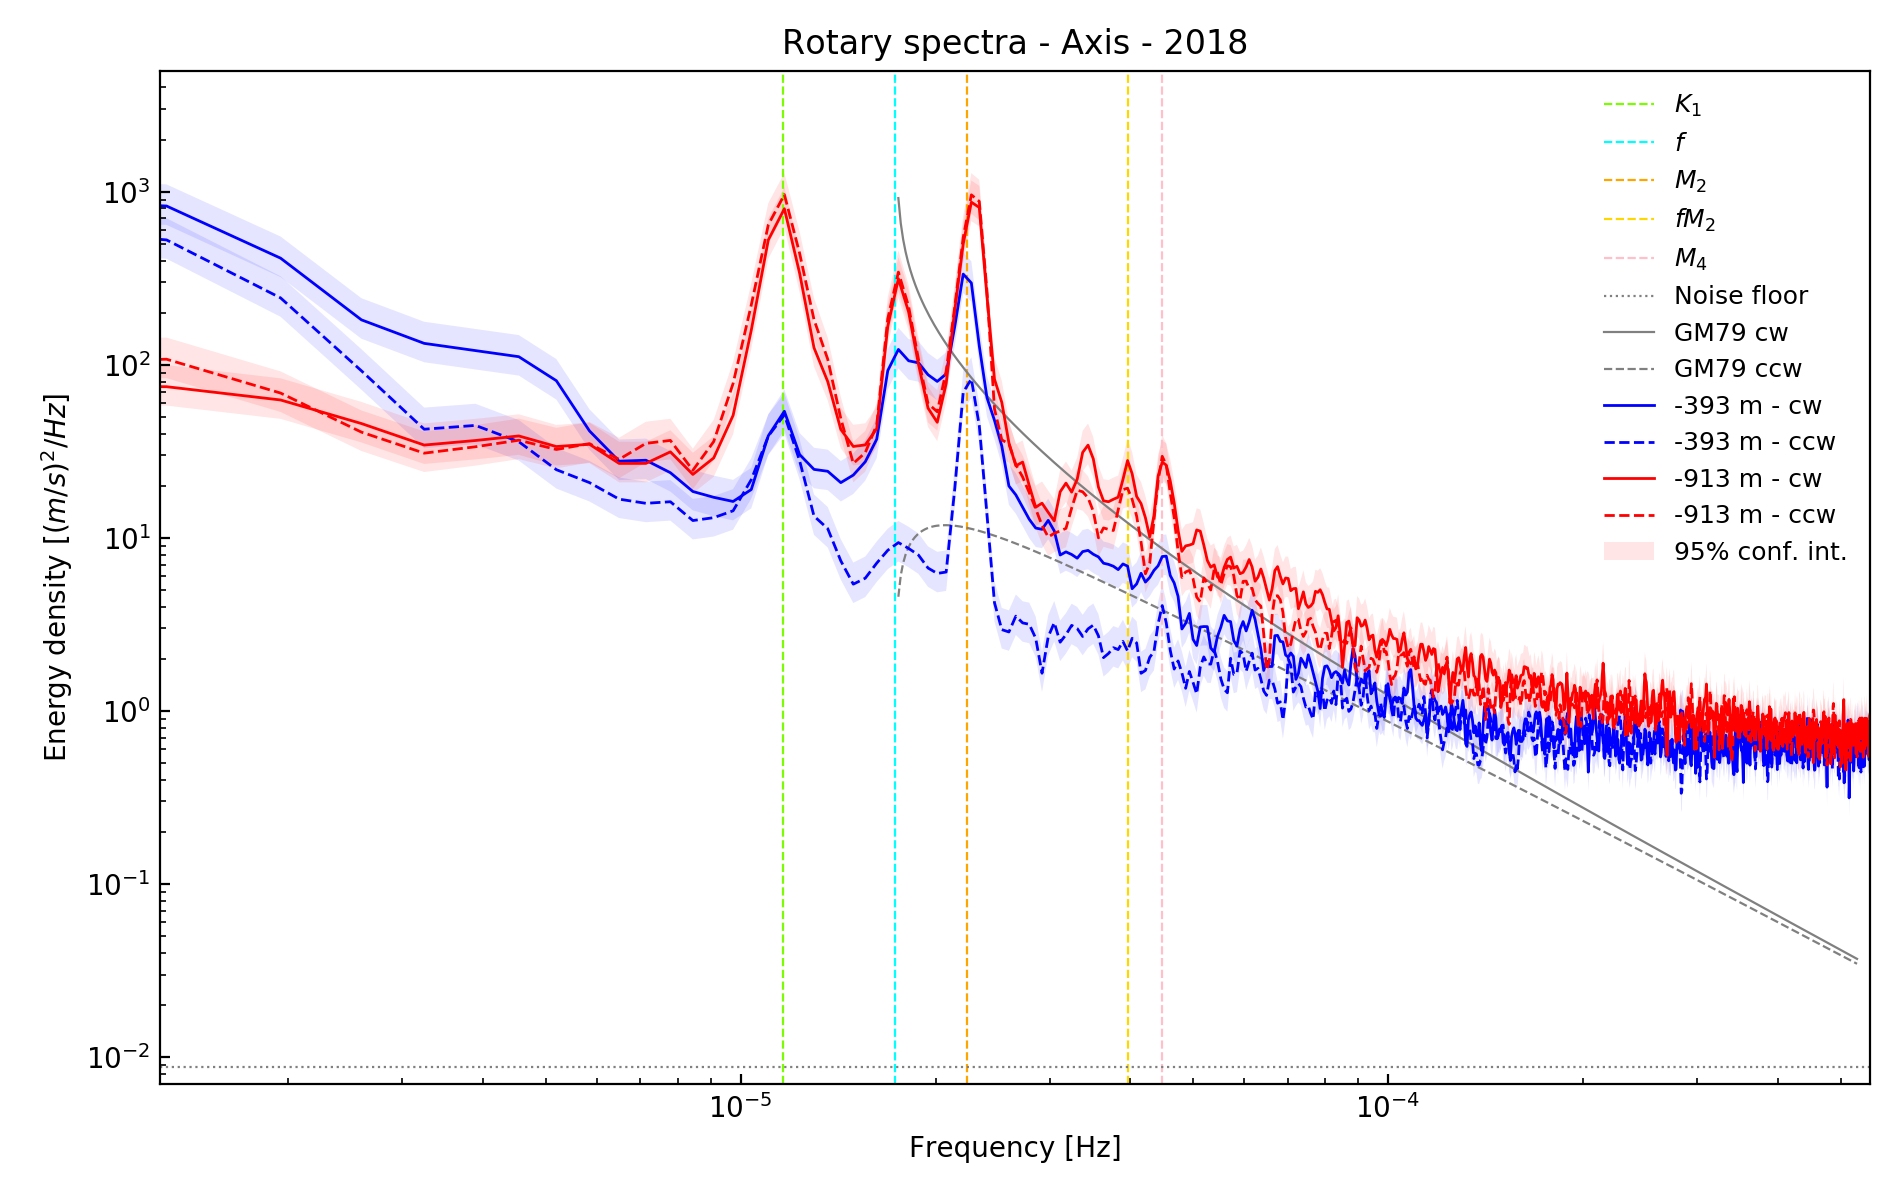

In [259]:
# plot rotary spectra

fig,ax = plt.subplots(1,1,figsize=(9.5,6))               # plot CCW and CW components
ax.set_title(f'Rotary spectra - {name} - {t_stamp}')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(f'Energy density [$(m/s)^2/Hz$]')
ax.set_ylim(7e-3,5e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 
ax.tick_params(axis='both', direction='in', which='both')

ax.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$") 
ax.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$")    
ax.axvline(2.236e-5, color ='orange',ls='--',lw=0.8,label = "$M_2$")
ax.axvline(3.968e-5, color ='gold',ls='--',lw=0.8,label = "$fM_2$")
ax.axvline(4.472e-5, color ='pink',ls='--',lw=0.8,label = "$M_4$")
ax.axhline(noise_floor,color='gray',ls=':',lw=0.8,label='Noise floor')
ax.loglog(gm_freq/(2*np.pi),gm_cw*(2*np.pi),color='gray',lw=0.8, label = 'GM79 cw') 
ax.loglog(gm_freq/(2*np.pi),gm_ccw*(2*np.pi),color='gray',lw=0.8,ls='--', label = 'GM79 ccw') 

ax.loglog(f_rot_up/3600, cw_real_up*3600, label=f'-{d_stamp_up} m - cw',color='blue',lw=1)
ax.loglog(f_rot_up/3600, ccw_real_up*3600, label=f'-{d_stamp_up} m - ccw',color='blue',ls='--',lw=1)
ax.loglog(f_rot_low/3600, cw_real_low*3600, label=f'-{d_stamp_low} m - cw',color='red',lw=1)
ax.loglog(f_rot_low/3600, ccw_real_low*3600, label=f'-{d_stamp_low} m - ccw',color='red',ls='--',lw=1)

ax.fill_between(f_rot_up/3600, cw_real_up_lower*3600, cw_real_up_upper*3600, facecolor='blue', alpha=0.1)
ax.fill_between(f_rot_up/3600, ccw_real_up_lower*3600, ccw_real_up_upper*3600, facecolor='blue', alpha=0.1)
ax.fill_between(f_rot_low/3600, cw_real_low_lower*3600, cw_real_low_upper*3600, facecolor='red', alpha=0.1)
ax.fill_between(f_rot_low/3600, ccw_real_low_lower*3600, ccw_real_low_upper*3600, facecolor='red', alpha=0.1, label='95% conf. int.')

fig.tight_layout()
plt.legend(loc='best',frameon=False,fontsize=9)
plt.show()

plt.savefig(fname='./plots/rot_plots/rot_'+adcp+'_'+t_stamp+'.pdf',format='pdf')

## Spectrograms

Creates a spectrogram for the rotated, cleaned, and mean-removed velocity data. Spectrograms have been 'whitened', and parameters adjusted (as in PSD) for optimal visual clarity.

In [260]:
# upper depth spectrogram process

# set velocity data for spectrogram process
d_idx_up = 0                                         # depth index, use -1 for lower, 0 for upper
d_stamp_up = str(int(depth[d_idx_up]))               # depth stamp for figures
spectro_u_up = uorig[:,d_idx_up]                 
spectro_u_up -= np.mean(uorig[:,d_idx_up])        # remove mean for spectrogram
spectro_v_up = vorig[:,d_idx_up]                 
spectro_v_up -= np.mean(vorig[:,d_idx_up])       

# get spectrogram
fs_x = 4                                       # sampling frequency per HOUR
window_x = 'parzen'                            # choose window option
spectro_u_up_f, spectro_u_up_t, spectro_u_up_Sxx = sig.spectrogram(spectro_u_up, fs_x, window=window_x, \
                                                    nperseg = 256, noverlap = 128, return_onesided=True)
spectro_v_up_f, spectro_v_up_t, spectro_v_up_Sxx = sig.spectrogram(spectro_v_up, fs_x, window=window_x, \
                                                    nperseg = 256, noverlap = 128, return_onesided=True)

# 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2
Sxx_u_up_white = np.copy(spectro_u_up_Sxx)
for i in range(len(spectro_u_up_t)):
    Sxx_u_up_white[:,i] = Sxx_u_up_white[:,i]*(spectro_u_up_f**2)
Sxx_v_up_white = np.copy(spectro_v_up_Sxx)
for i in range(len(spectro_v_up_t)):
    Sxx_v_up_white[:,i] = Sxx_v_up_white[:,i]*(spectro_v_up_f**2)

# convert spectro_t to datetime for x-axis on plots
spectro_t4_up = spectro_v_up_t*4
spectro_time_len_up = len(spectro_t4_up)
spectro_time_axis_up = np.zeros([spectro_time_len_up],dtype='datetime64[s]')
for i in range(spectro_time_len_up):
    j = np.int(spectro_t4_up[i])
    spectro_time_axis_up[i] = time[j]

In [261]:
# lower depth spectrogram process

# set velocity data for spectrogram process
d_idx_low = -1                                         # depth index, use -1 for lower
d_stamp_low = str(int(depth[d_idx_low]))               # depth stamp for figures
spectro_u_low = uorig[:,d_idx_low]                 
spectro_u_low -= np.mean(uorig[:,d_idx_low])           # remove mean for spectrogram
spectro_v_low = vorig[:,d_idx_low]                 
spectro_v_low -= np.mean(vorig[:,d_idx_low])       

# get spectrogram
fs_x = 4                                       # sampling frequency per HOUR
window_x = 'parzen'                            # choose window option
spectro_u_low_f, spectro_u_low_t, spectro_u_low_Sxx = sig.spectrogram(spectro_u_low, fs_x, window=window_x, \
                                                    nperseg = 256, noverlap = 128, return_onesided=True)
spectro_v_low_f, spectro_v_low_t, spectro_v_low_Sxx = sig.spectrogram(spectro_v_low, fs_x, window=window_x, \
                                                    nperseg = 256, noverlap = 128, return_onesided=True)

# 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2
Sxx_u_low_white = np.copy(spectro_u_low_Sxx)
for i in range(len(spectro_u_low_t)):
    Sxx_u_low_white[:,i] = Sxx_u_low_white[:,i]*(spectro_u_low_f**2)
Sxx_v_low_white = np.copy(spectro_v_low_Sxx)
for i in range(len(spectro_v_low_t)):
    Sxx_v_low_white[:,i] = Sxx_v_low_white[:,i]*(spectro_v_low_f**2)

# convert spectro_t to datetime for x-axis on plots
spectro_t4_low = spectro_v_low_t*4
spectro_time_len_low = len(spectro_t4_low)
spectro_time_axis_low = np.zeros([spectro_time_len_low],dtype='datetime64[s]')
for i in range(spectro_time_len_low):
    j = np.int(spectro_t4_low[i])
    spectro_time_axis_low[i] = time[j]

<IPython.core.display.Javascript object>


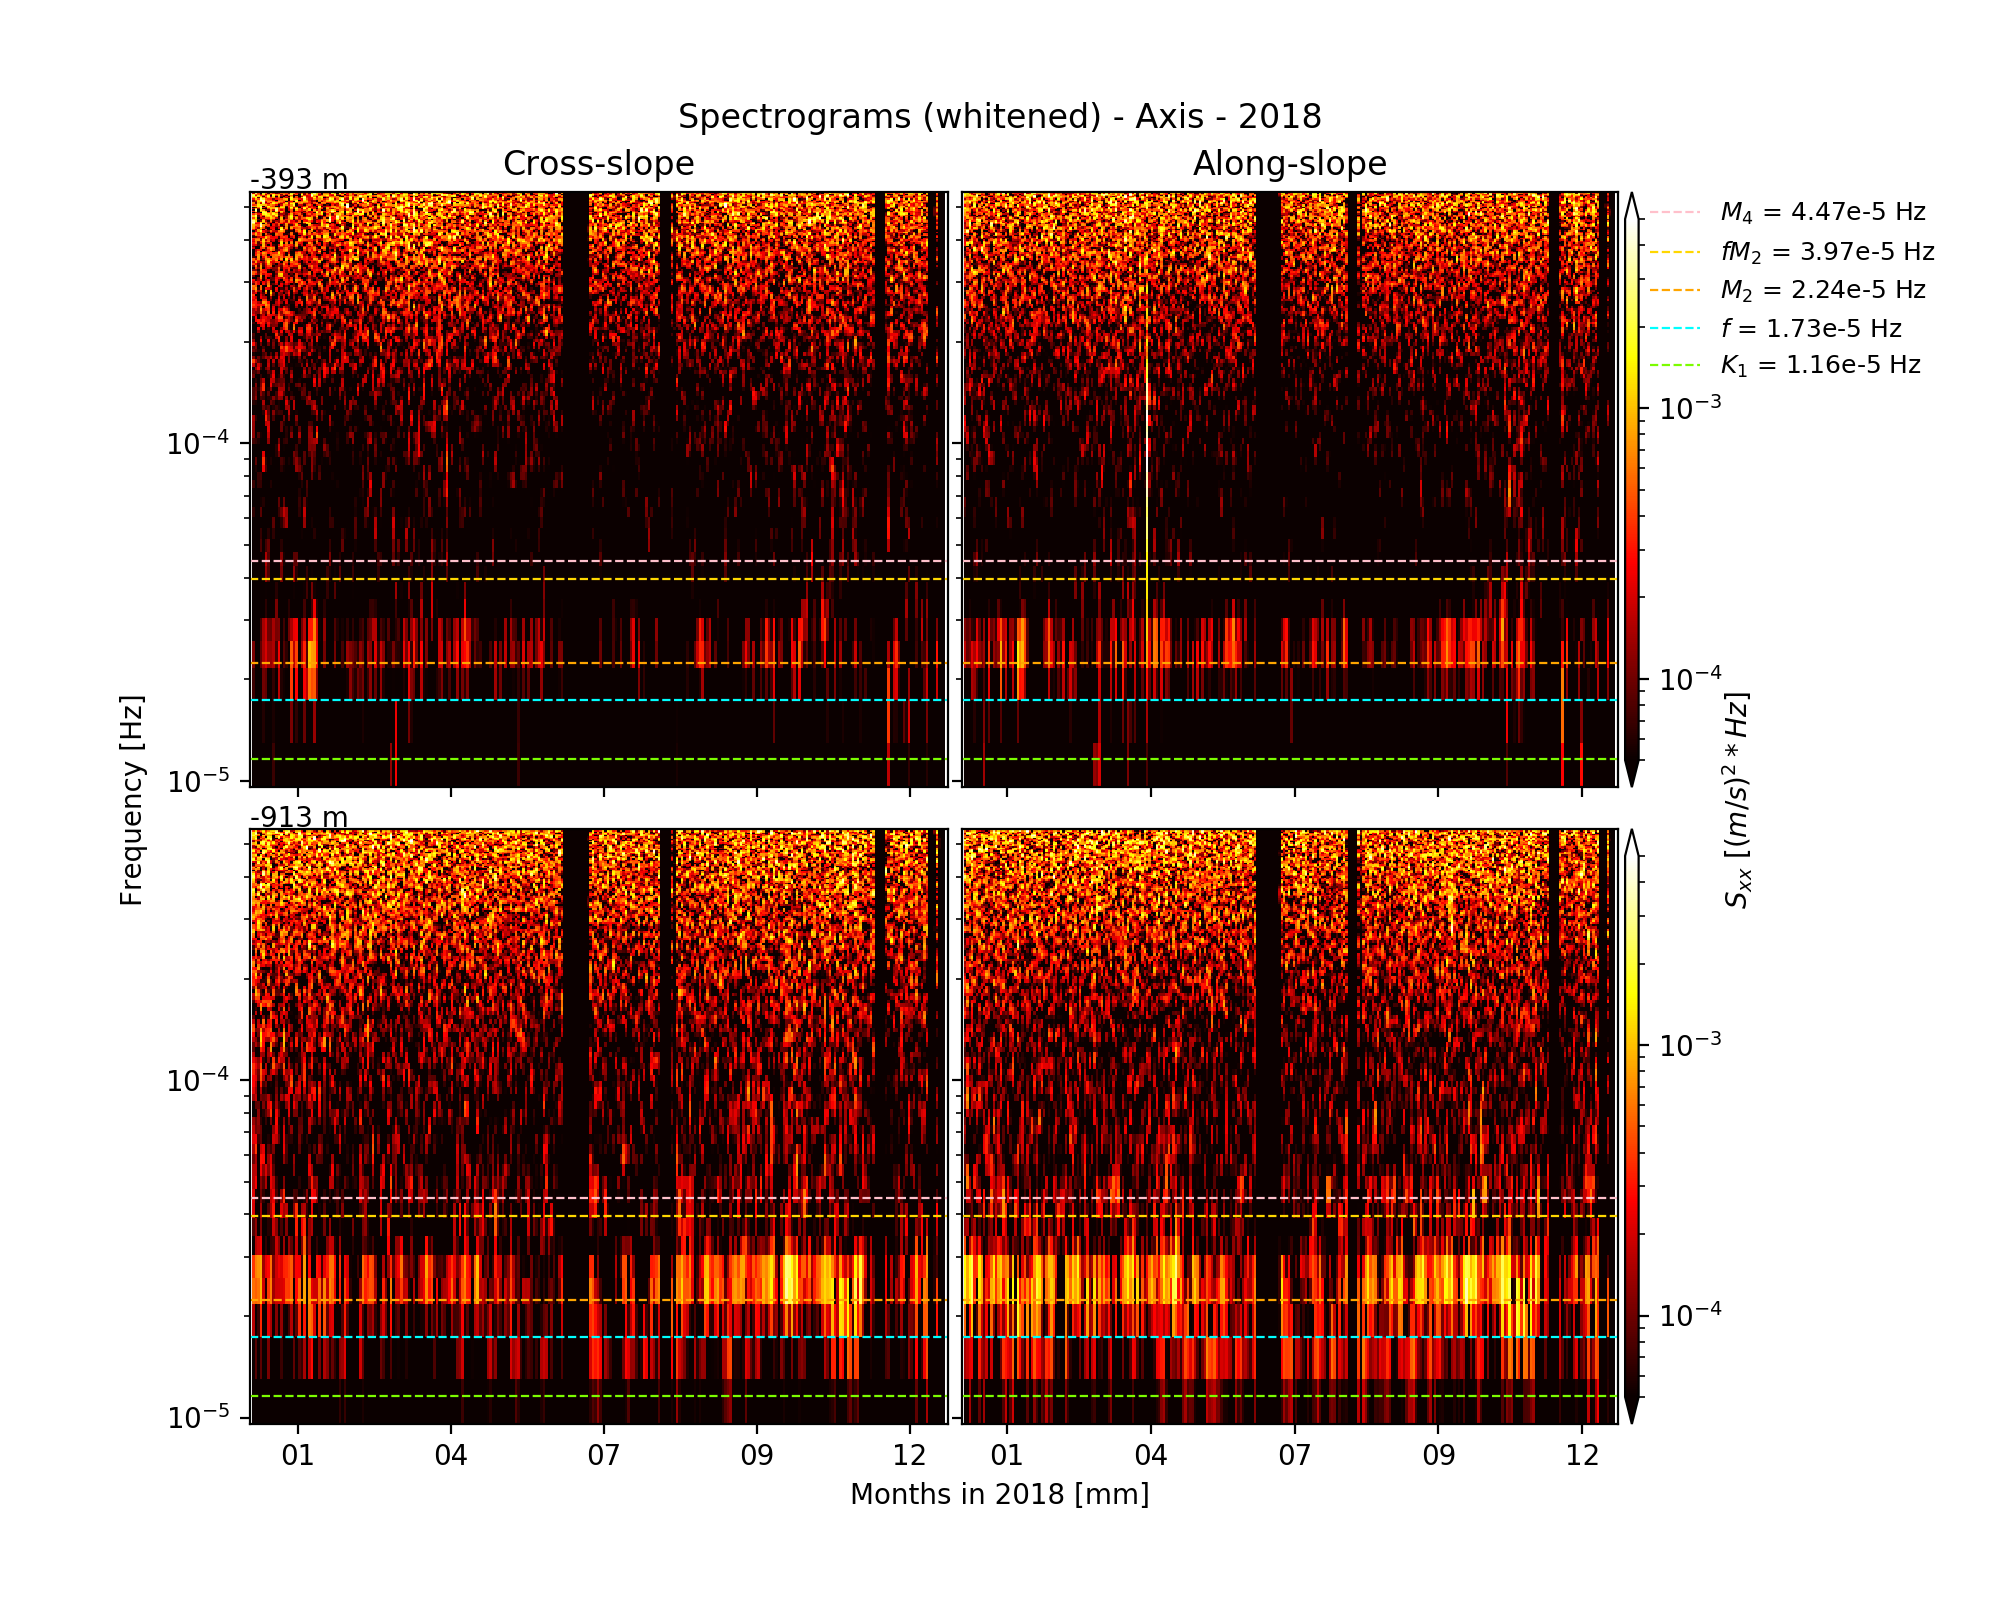

In [263]:
# plot spectrogram

fig, axs = plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)
(ax0,ax1),(ax2,ax3) = axs
fig.subplots_adjust(hspace=0.07, wspace=0.02)
fig.text(0.5, 0.92, f'Spectrograms (whitened) - {name} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
fig.text(0.86, 0.5, '$S_{xx}$ [$(m/s)^2*Hz$]', va='center', rotation='vertical')
fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center')
fig.text(0.125,0.882,f'-{d_stamp_up} m')
fig.text(0.125,0.483,f'-{d_stamp_low} m')
ax0.set_title('Cross-slope')
ax1.set_title('Along-slope')

im0 = ax0.pcolormesh(spectro_time_axis_up, spectro_u_up_f/3600, Sxx_u_up_white, rasterized=True, \
                    norm=colors.LogNorm(vmin=5e-5, vmax=5e-3), cmap='hot')  
im1 = ax1.pcolormesh(spectro_time_axis_up, spectro_v_up_f/3600, Sxx_v_up_white, rasterized=True, \
                    norm=colors.LogNorm(vmin=5e-5, vmax=5e-3), cmap='hot')  
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')
im2 = ax2.pcolormesh(spectro_time_axis_low, spectro_u_low_f/3600, Sxx_u_low_white, rasterized=True, \
                    norm=colors.LogNorm(vmin=5e-5, vmax=5e-3), cmap='hot')  
im3 = ax3.pcolormesh(spectro_time_axis_low, spectro_v_low_f/3600, Sxx_v_low_white, rasterized=True, \
                    norm=colors.LogNorm(vmin=5e-5, vmax=5e-3), cmap='hot')  
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')

ax0.set_yscale('log')
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_xlim(start_date,end_date)
#ax0.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))
ax0.xaxis.set_major_locator(plt.MaxNLocator(6))

ax0.axhline(4.472e-5, color ='pink',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
ax0.axhline(3.968e-5, color ='gold',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
ax0.axhline(2.236e-5, color ='orange',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
ax0.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz") 
ax0.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") 
ax1.axhline(4.472e-5, color ='pink',ls='--',lw=0.8)
ax1.axhline(3.968e-5, color ='gold',ls='--',lw=0.8)
ax1.axhline(2.236e-5, color ='orange',ls='--',lw=0.8)
ax1.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8) 
ax1.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8) 
ax2.axhline(4.472e-5, color ='pink',ls='--',lw=0.8)
ax2.axhline(3.968e-5, color ='gold',ls='--',lw=0.8)
ax2.axhline(2.236e-5, color ='orange',ls='--',lw=0.8)
ax2.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8) 
ax2.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8) 
ax3.axhline(4.472e-5, color ='pink',ls='--',lw=0.8)
ax3.axhline(3.968e-5, color ='gold',ls='--',lw=0.8)
ax3.axhline(2.236e-5, color ='orange',ls='--',lw=0.8)
ax3.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8) 
ax3.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8) 

plt.subplots_adjust(right=0.83)
fig.legend(loc=(0.82,0.756), framealpha=0.8, facecolor='whitesmoke', fontsize=9, frameon=False)
plt.show()

plt.savefig(fname='./plots/spectro_plots/spectro_'+adcp+'_'+t_stamp+'.pdf',format='pdf')

In [27]:
# spectrogram process for w (run above, first)

# spectro_w = worig[:,d_idx]                 
# spectro_w -= np.nanmean(worig[:,d_idx])       # remove mean for spectrogram

# # get spectrogram
# spectro_w_f, spectro_w_t, spectro_w_Sxx = sig.spectrogram(spectro_w, fs_x, window=window_x, \
#                                                     nperseg = 256, noverlap = 128, return_onesided=True)
# # 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2
# Sxx_w_white = np.copy(spectro_w_Sxx)
# for i in range(len(spectro_w_t)):
#     Sxx_w_white[:,i] = Sxx_w_white[:,i]*(spectro_w_f**2)

In [28]:
# plot w spectrogram (adjust to match horizontal)

# fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True, sharey=True)
# fig.text(0.5, 0.915, f'$w$ Spectrogram - {name} (-{d_stamp} m) - {t_stamp}', ha='center', fontsize=12)
# fig.text(0.06, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
# fig.text(0.86, 0.5, '$S_{xx}$ [$(m/s)^2*Hz$]', va='center', rotation='vertical')
# fig.text(0.5, 0.04, f'Months in {t_stamp} [mm]', ha='center')

# im = ax.pcolormesh(spectro_time_axis, spectro_w_f/3600, Sxx_w_white, rasterized=True, \
#                     norm=colors.LogNorm(vmin=1e-6, vmax=5e-3), cmap='hot')  
# cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.01, aspect=40, extend='both')

# ax.set_yscale('log')
# date_form = pldates.DateFormatter("%m")
# ax.xaxis.set_major_formatter(date_form)
# ax.set_xlim(start_date,end_date)
# #ax.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))

# ax.axhline(4.472e-5, color ='lime',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
# ax.axhline(3.968e-5, color ='orange',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
# ax.axhline(2.236e-5, color ='gold',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
# ax.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz") 
# ax.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") 

# plt.subplots_adjust(right=0.84)
# fig.legend(loc=(0.82,0.75), framealpha=0.8, facecolor='whitesmoke', fontsize=9, frameon=False)
# plt.show()

# plt.savefig(fname='./plots/spectro_plots/spectro_'+adcp+'_w_'+d_stamp+'_'+t_stamp+'.pdf',format='pdf')

# Velocities

Creates time and depth velocity plots from rotated and cleaned data.

<IPython.core.display.Javascript object>


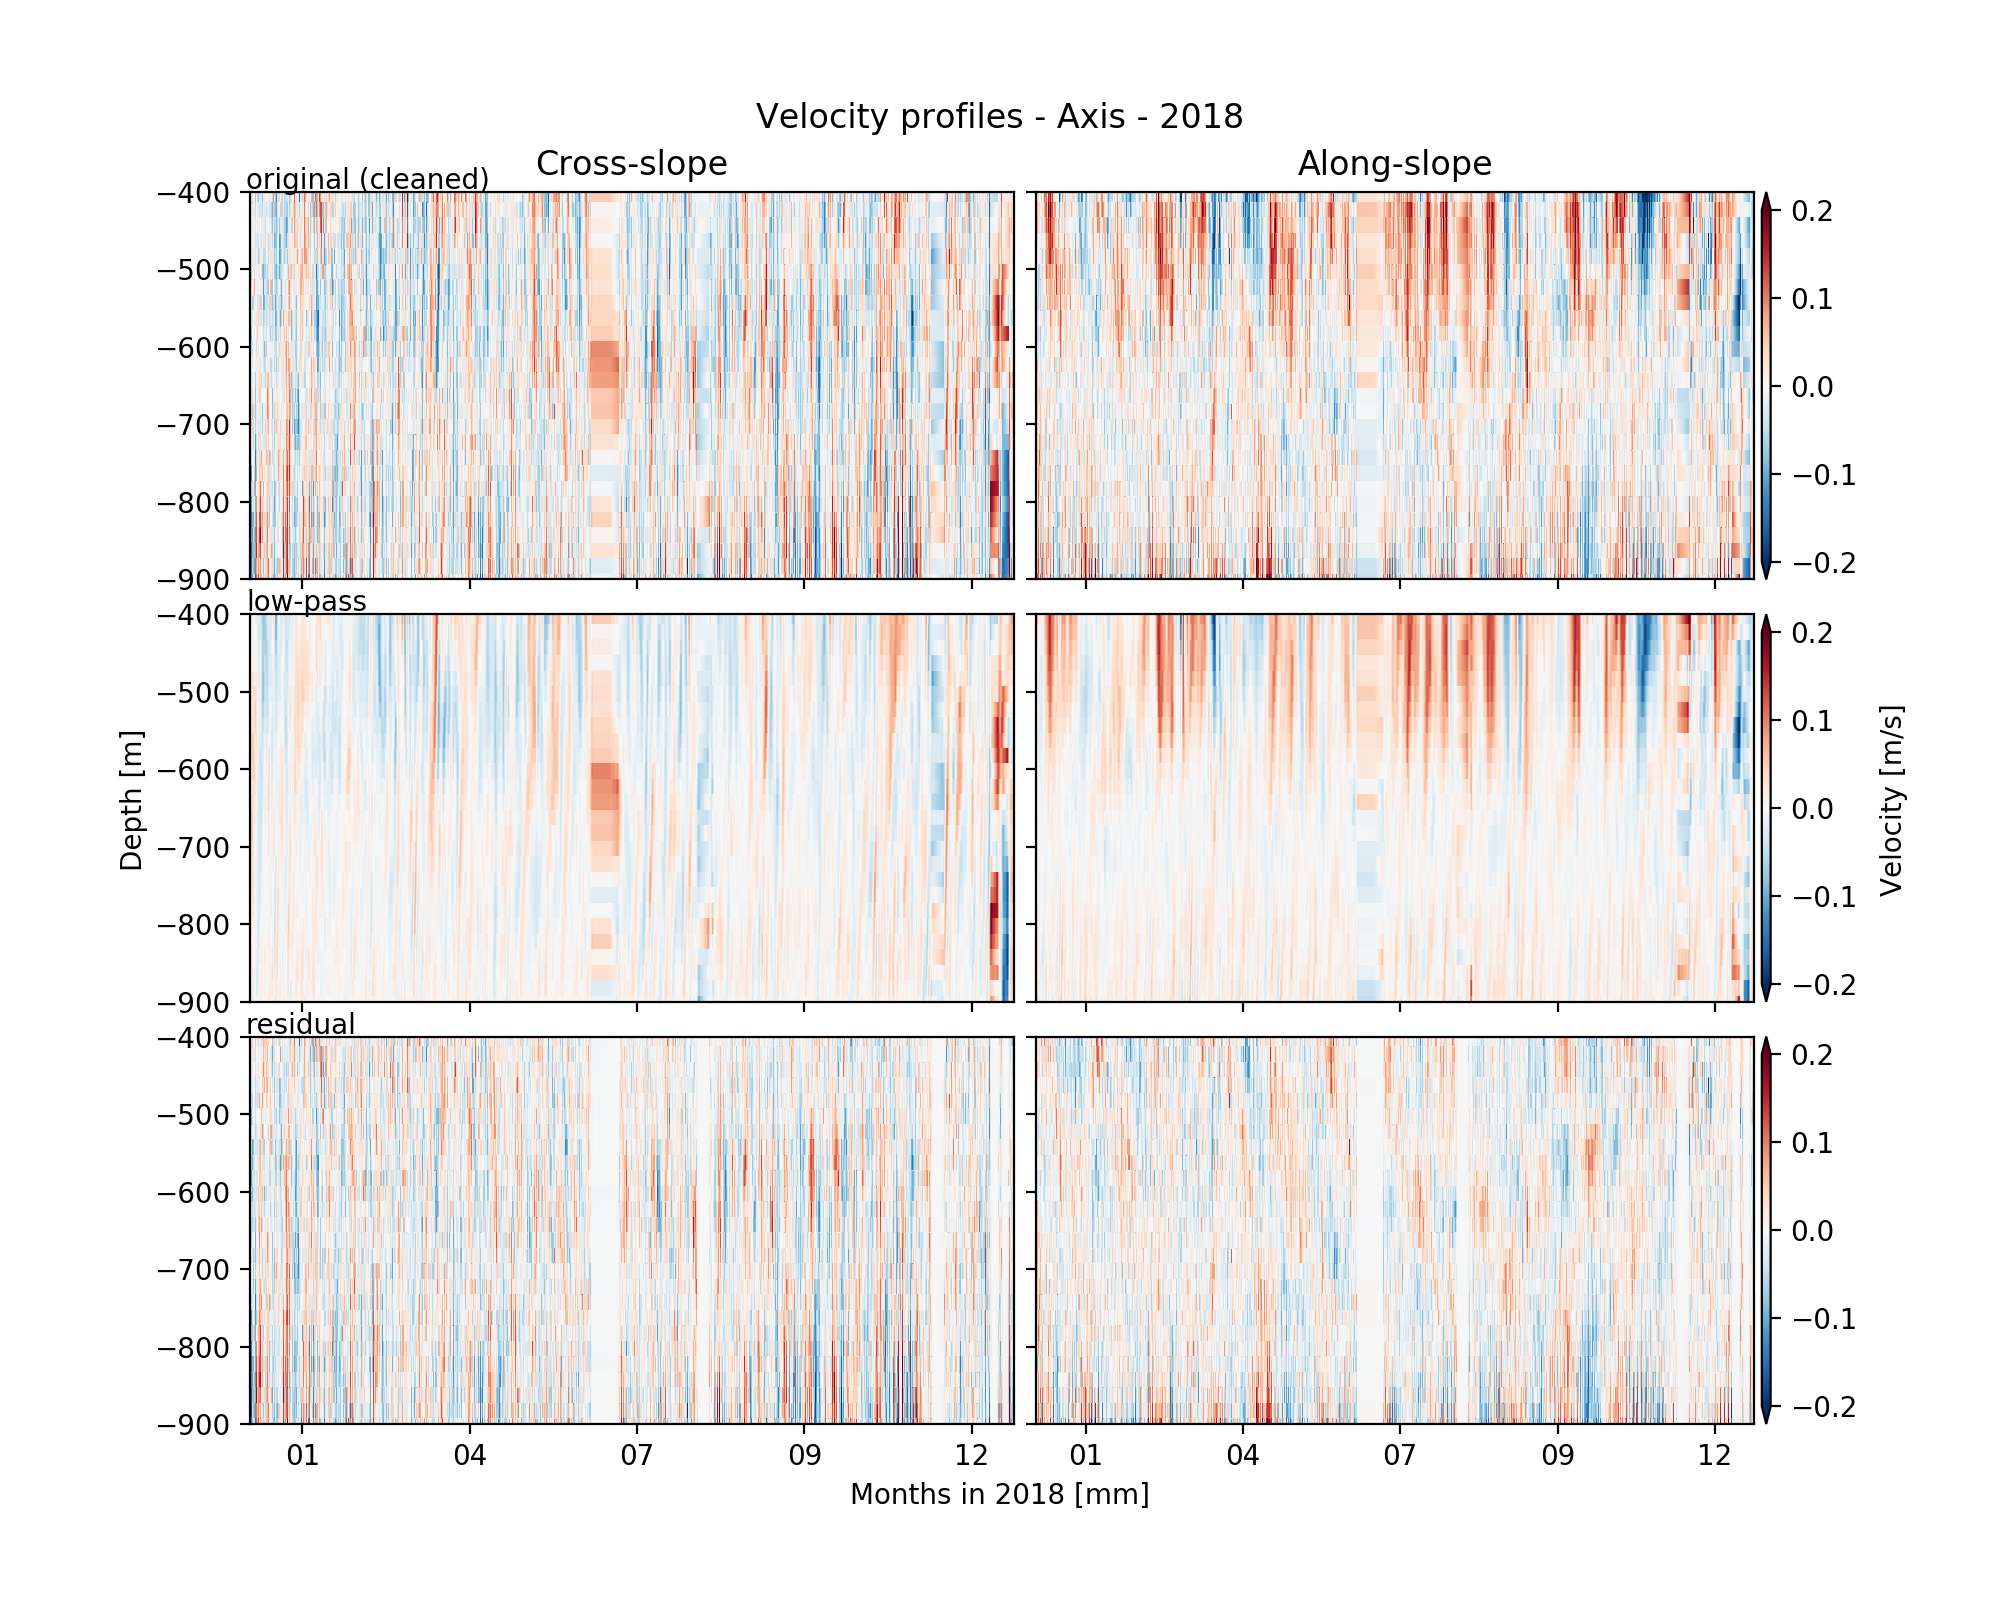

In [264]:
# plot velocity data

fig, axs = plt.subplots(3,2, figsize=(10,8), sharex = True, sharey = True)
(ax1,ax4),(ax2,ax5),(ax3,ax6) = axs
fig.subplots_adjust(hspace = 0.09,wspace = 0.03)
fig.text(0.5, 0.92, f'Velocity profiles - {name} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (cleaned)', va='center')
fig.text(0.123, 0.623, 'low-pass', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center')
ax1.set_title('Cross-slope')
ax4.set_title('Along-slope')

vmin = -0.20
vmax = 0.20
im1 = ax1.pcolormesh(time, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
im2 = ax2.pcolormesh(time, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
im3 = ax3.pcolormesh(time, -depth, uhp.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
im4 = ax4.pcolormesh(time, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
cbar4 = fig.colorbar(im4, ax=ax4, fraction=0.05, pad=0.01, aspect=40, extend='both')
im5 = ax5.pcolormesh(time, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=40, extend='both')
im6 = ax6.pcolormesh(time, -depth, vhp.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
cbar6 = fig.colorbar(im6, ax=ax6, fraction=0.05, pad=0.01, aspect=40, extend='both')

if adcp == 'Axis' or adcp == 'Axis55':
    ax6.set_ylim(-900,-400)
elif adcp == 'Slope':
    ax6.set_ylim(-330,-100)
    
date_form = pldates.DateFormatter("%m")
ax6.xaxis.set_major_formatter(date_form)
ax6.set_xlim(start_date,end_date)
#ax6.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))
ax6.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()

plt.savefig(fname='./plots/vel_plots/vel_'+adcp+'_'+t_stamp+'.pdf',format='pdf')

In [30]:
# plot w velocities (adjust to match horizontal)

# fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,8),sharex=True,sharey=True)
# fig.subplots_adjust(hspace = 0.08,wspace = 0.05)
# fig.text(0.5, 0.92, f'$w$ velocity profile - {name} - {t_stamp}', ha='center', fontsize=12)
# fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
# fig.text(0.123, 0.887, 'original (cleaned)', va='center')
# fig.text(0.123, 0.623, 'low-pass (mean currents)', va='center')
# fig.text(0.123, 0.360, 'residual', va='center')
# fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
# fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center')

# im1 = ax1.pcolormesh(time, -depth, worig.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
# im2 = ax2.pcolormesh(time, -depth, wlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
# im3 = ax3.pcolormesh(time, -depth, whp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
# cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')
# cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')
# cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')

# if adcp == 'Slope':
#     ax1.set_ylim(-380,-13)
# elif adcp == 'Axis':
#     ax1.set_ylim(-970,-336)
# elif adcp == 'Axis55':
#     ax1.set_ylim(-970,-336)

# date_form = pldates.DateFormatter("%m")
# ax3.xaxis.set_major_formatter(date_form)
# ax3.set_xlim(start_date,end_date)
# #ax3.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))
# ax3.xaxis.set_major_locator(plt.MaxNLocator(6))

# plt.show()

# plt.savefig(fname='./plots/vel_plots/vel_w_'+adcp+'_'+t_stamp+'.pdf',format='pdf')